In [51]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium
from models.WienerNet import Wiener, WienerNet

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load in Brain Data

(512, 2000)
268466.6055 -253412.159


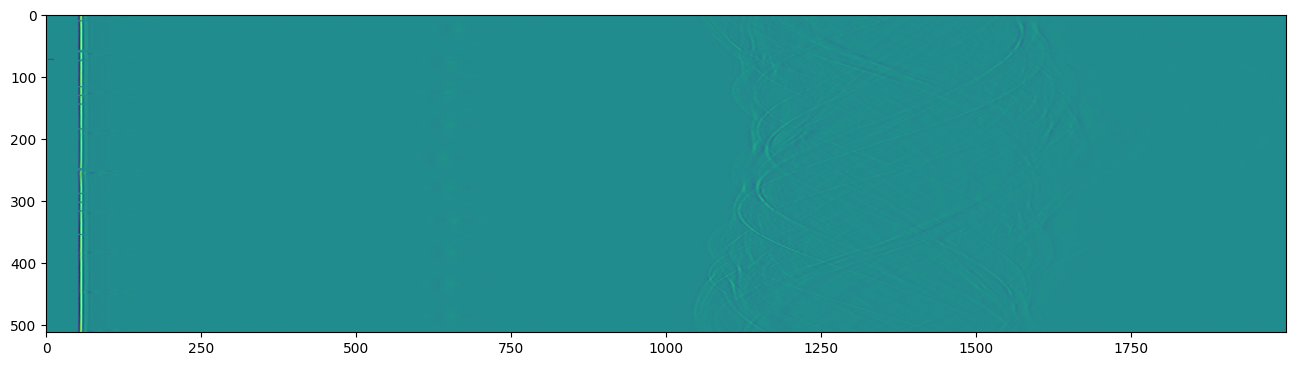

In [52]:
data_path = '/mnt/WD6TB/tianaoli/brains/'
# data = h5py.File('data/Sinogram_averaged.mat')
# sinogram = np.array(data['Sinogram_averaged'])
data = h5py.File('data/ANIMAL_LAYER.mat')
sinogram = np.array(data['Sinogram'])
print(sinogram.shape)
print(sinogram.max(), sinogram.min())
fig, ax = plt.subplots(figsize=(16,5))
ax.imshow(sinogram)
plt.show()

(2000,) (1, 2000)


(0.0, 2000.0)

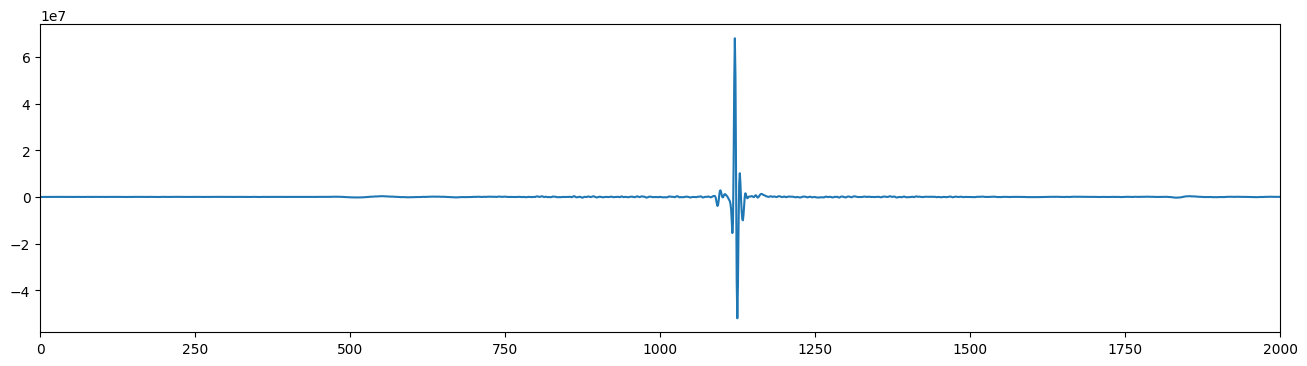

In [53]:
EIR_data = h5py.File('data/EIR_TUNGSTEN.mat')
EIR = np.array(EIR_data['EIR_AVE_20180516_LEFT'])
time = np.linspace(0, 2000, 2000)
print(time.shape, EIR.shape)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR))
plt.xlim(0,2000)

In [54]:
def transducer_response(sensor_data, T_sample):

    return -2 * (sensor_data[:,1:] - sensor_data[:,:-1]) # / T_sample

def deconv(sensor_data, EIR):

    return ifft(fft(sensor_data)*fft(EIR)).real

# sinogram = deconv(sinogram, EIR)
# sinogram = transducer_response(sinogram, 0)

In [55]:
Nx, Ny = 512, 512
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 5e-5, 5e-5 # 7.5e-5, 7.5e-5 # 1.05*2*R_ring/Ny
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
kgrid.dt = 1/10e6

In [56]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum recontructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum recontruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the recontructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)
    
    R_ring = R_ring #- 40e-6 - 120e-6 * np.cos(2 * angle_transducer) + 5e-5 # Ring Array Correction 

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

In [57]:
# delay_step, offset = 1e-4, -1.55e-3 # [m]
delay_step, offset = 1e-4, -1.30e-3 # [m]
n_delays = 8
d_delays = np.linspace(-(n_delays/2-1), n_delays/2, n_delays) * delay_step + offset
print(d_delays)
recons = []
for d_delay in d_delays:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          V_sound=1500,
                          Sinogram=sinogram,
                          ImageX=kgrid.x_vec[:],
                          ImageY=kgrid.y_vec[:],
                          d_delay=d_delay)
    recons.append(recon)

[-0.0016 -0.0015 -0.0014 -0.0013 -0.0012 -0.0011 -0.001  -0.0009]


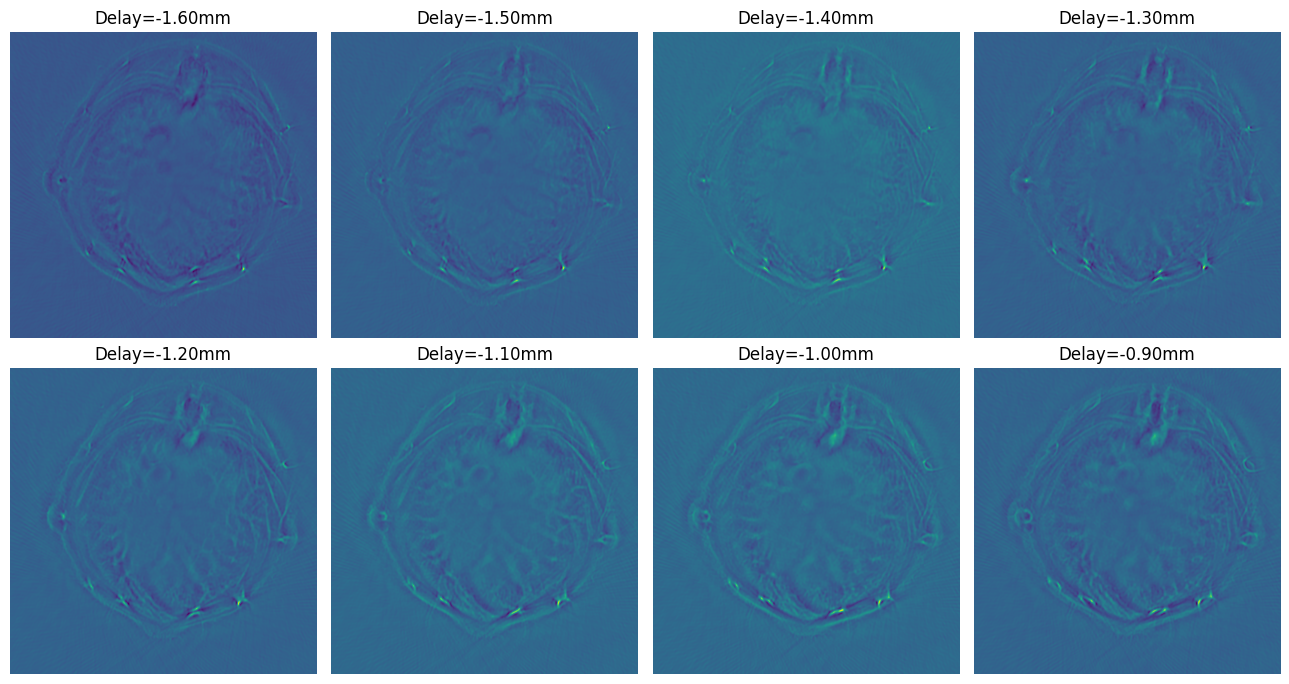

In [58]:
plt.figure(figsize=(13, 7))
for idx, d_delay in enumerate(d_delays):
    ax1 = plt.subplot(2,4,idx+1)
    plt.imshow(recons[idx])
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
plt.tight_layout()

### Sinogram

Text(0.5, 1.0, 'Histogram')

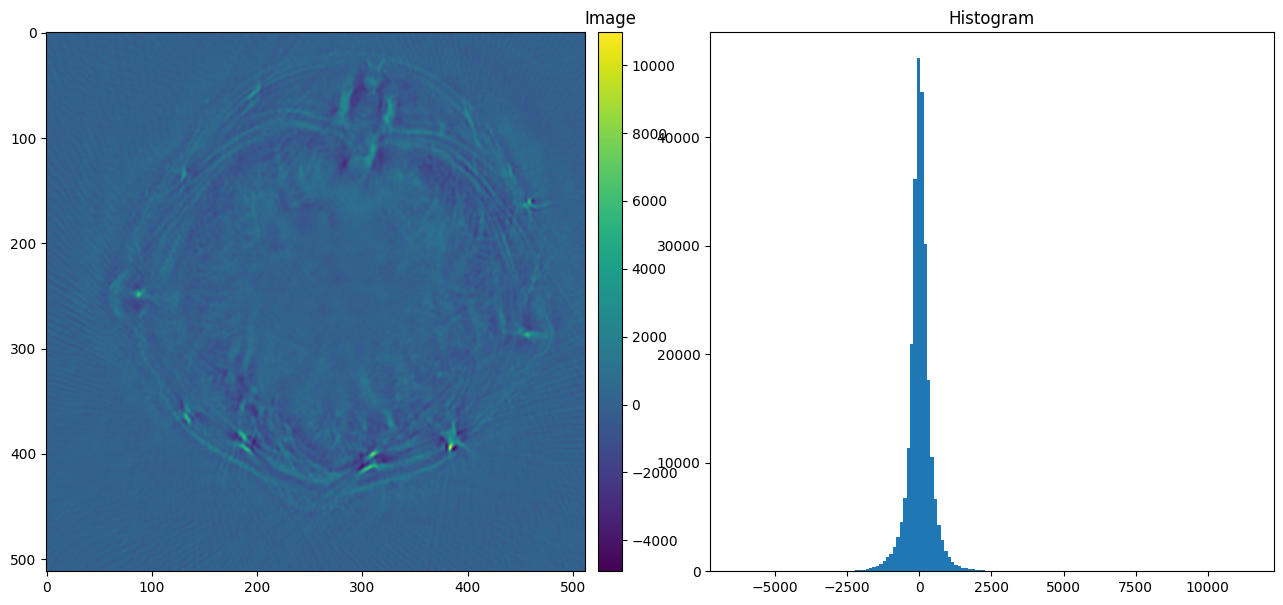

In [59]:
fig = plt.figure(figsize=(16,7))
ax1 = plt.subplot(1,2,1)
plt.imshow(recons[3])
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(recons[2].ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### Wiener Deconvolution

In [60]:
data_path = '/mnt/WD6TB/tianaoli/dataset/Brain/'

gt_full = recons[3]
obss, psfs = [], []
for i in range(7):
    for j in range(7):
        psf = torch.load(os.path.join(data_path, 'psf', f"psf_{i*7+j}.pth"))
        psfs.append(psf)
        obs = torch.Tensor(gt_full[32*i:32*i+64, 32*j:32*j+64])
        obss.append(obs)

In [61]:
ncs = [32, 16, 8]
rec_fulls = []
pretrained_epochs = [118, 156, 170] # MultiScale
loss = 'MultiScale' # 'MSE'
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    pretrained_file = os.path.join('../saved_models_Brain/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {pretrained_file}.')
    model.eval()
    
    rec_full, weights = np.zeros_like(gt_full), np.zeros_like(gt_full)
    for i in range(7):
        for j in range(7):
            obs, psf = obss[i*7+j], psfs[i*7+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[32*i:32*i+64, 32*j:32*j+64] += rec
            weights[32*i:32*i+64, 32*j:32*j+64] += 1
    rec_fulls.append(rec_full/weights)

Successfully loaded in ../saved_models_Brain/WienerNet_32channels_MultiScale_118epochs.pth.
Successfully loaded in ../saved_models_Brain/WienerNet_16channels_MultiScale_156epochs.pth.


/tmp/ipykernel_1076057/2902410796.py:24: RuntimeWarning: invalid value encountered in true_divide
  rec_fulls.append(rec_full/weights)


Successfully loaded in ../saved_models_Brain/WienerNet_8channels_MultiScale_170epochs.pth.


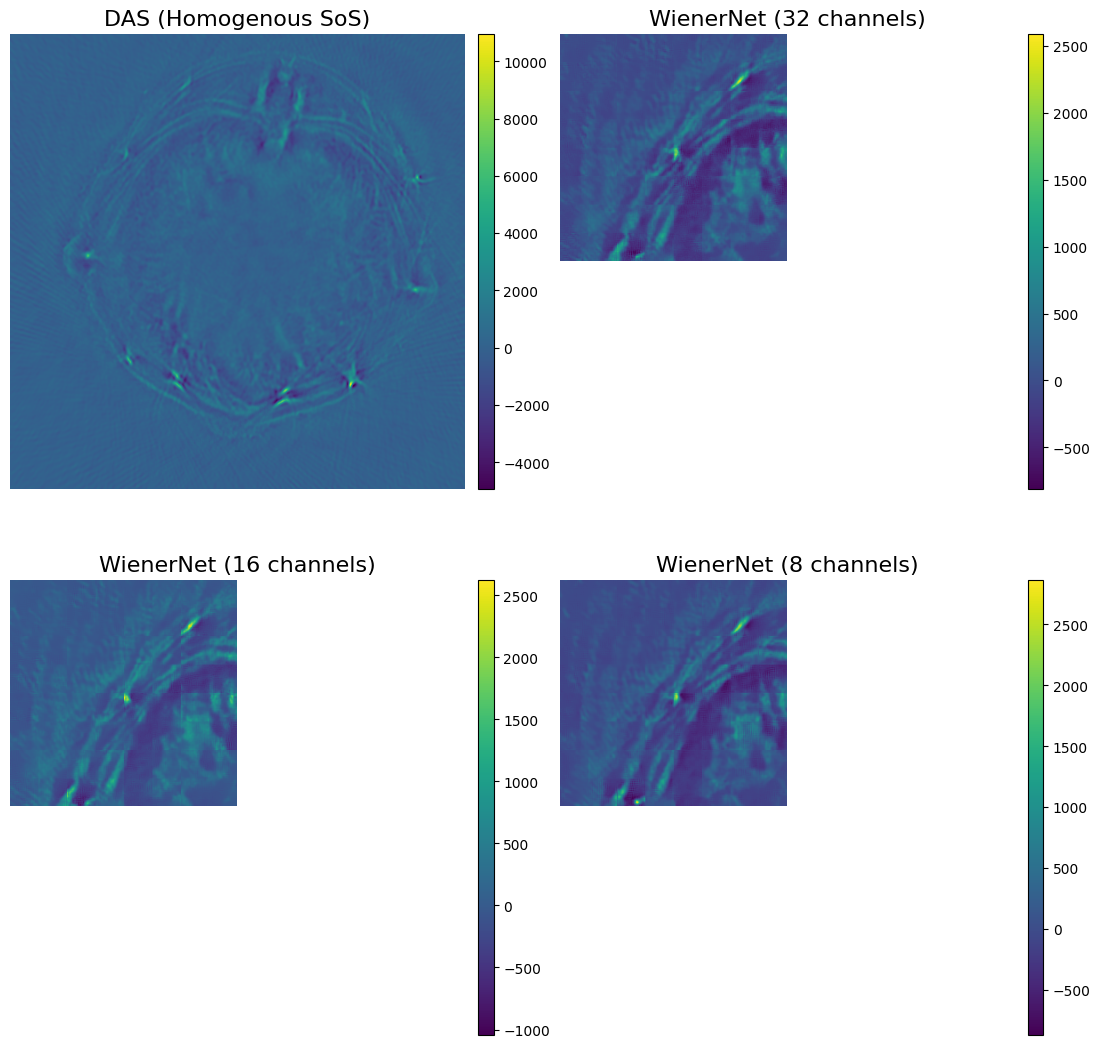

In [62]:
fig = plt.figure(figsize=(13, 13))

ax2 = plt.subplot(2,2,1)
plt.imshow(gt_full)
plt.title('DAS (Homogenous SoS)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,2,2)
plt.imshow(rec_fulls[0])
plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,2,3)
plt.imshow(rec_fulls[1])
plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,2,4)
plt.imshow(rec_fulls[2])
plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
cb = plt.colorbar(cax=cax)

# plt.tight_layout()